In [42]:
import os
from os.path import join
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import keras
from keras import layers, Input, models
import matplotlib
from matplotlib import font_manager, rc, gridspec
import matplotlib.pyplot as plt
import warnings
import itertools
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow_addons.metrics
import cv2
import random
from tqdm.keras import TqdmCallback
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
#warnings.filterwarnings("ignore")

In [2]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [3]:
# 환경 설정
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
#print(font_list[:])
%matplotlib inline


In [4]:
import mapply
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=16,
    progressbar=True
)
tqdm.pandas()

font_path = '/usr/share/fonts/NanumGothic.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', family='NanumGothic')

In [5]:
#최초 실행시에만 True
is_first = False

In [6]:
# GPU 메모리 최대 사용을 막기 위한 memory_growth  설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [7]:
#최초 실행시 전체 데이터 로드
if is_first:
    df=pd.read_pickle("LSWMD.pkl")
    df.info()

In [8]:
#라벨링 필드 치환을 위한 맵핑 선언
LabelMapping = {
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8
}

In [9]:
#불량 타입에 대한 라벨링 적용
if is_first:
    df['failureNum']=df.failureType
    df = df.replace({'failureNum':LabelMapping})

In [10]:
if is_first:
    print('라벨링이 있는 건수 : ', len(df[(df['failureNum']>=0) & (df['failureNum']<=7)]))
    print('라벨링이 없는 건수 : ', len(df[df['failureNum']==8]))

In [11]:
#학습에 사용될 실제 데이터 로드
if is_first:
    df_wafermap = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
    df_wafermap = df_wafermap.reset_index()
    df_wafermap.to_pickle('LSWMD_wafermap.pkl')
else:
    df_wafermap = pd.read_pickle("LSWMD_wafermap.pkl")

In [12]:
#불량 라벨의 array 데이터를 중첩루프에서 string 추출
df_wafermap['failureType'] = df_wafermap['failureType'].apply(lambda x: list(itertools.chain.from_iterable(x))[0])
df_wafermap['trianTestLabel'] = df_wafermap['trianTestLabel'].apply(lambda x: list(itertools.chain.from_iterable(x))[0])

In [13]:
#불량 패턴만 추출
plt_label_values = np.unique(df_wafermap[(df_wafermap['failureNum']>=0) 
                                         & (df_wafermap['failureNum']<=7)].failureNum, return_counts=True)
df_label_values = df_wafermap[(df_wafermap['failureNum']>=0) & (df_wafermap['failureNum']<=7)]
df_label_values = df_label_values.reset_index()

/tmp/ipykernel_632965/1968714749.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


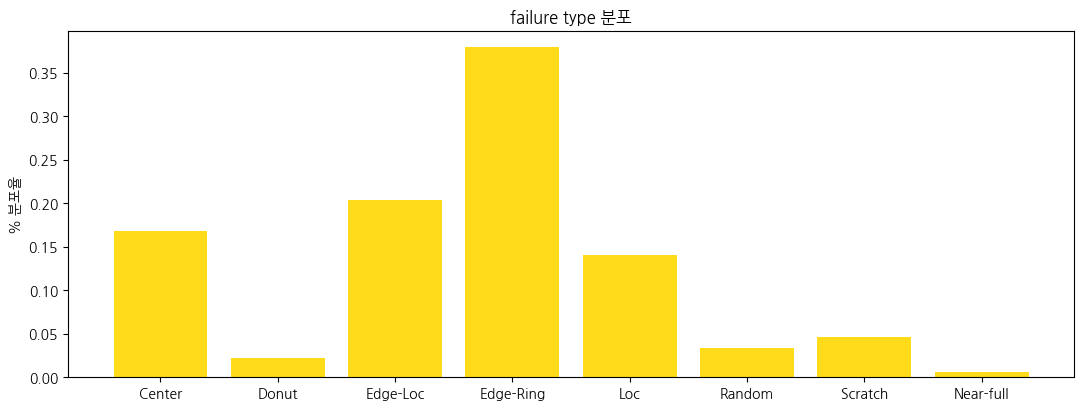

In [14]:
#불량 종류 시각화
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax = plt.subplot(gs[1])
labels = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax.bar(plt_label_values[0],plt_label_values[1]/df_label_values.shape[0], color='gold', align='center', alpha=0.9)
ax.set_title("failure type 분포")
ax.set_ylabel("% 분포율")
ax.set_xticklabels(labels)
plt.show()

In [ ]:
#불량 종류 시각화 - 2
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_label_values.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_label_values.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_label_values.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

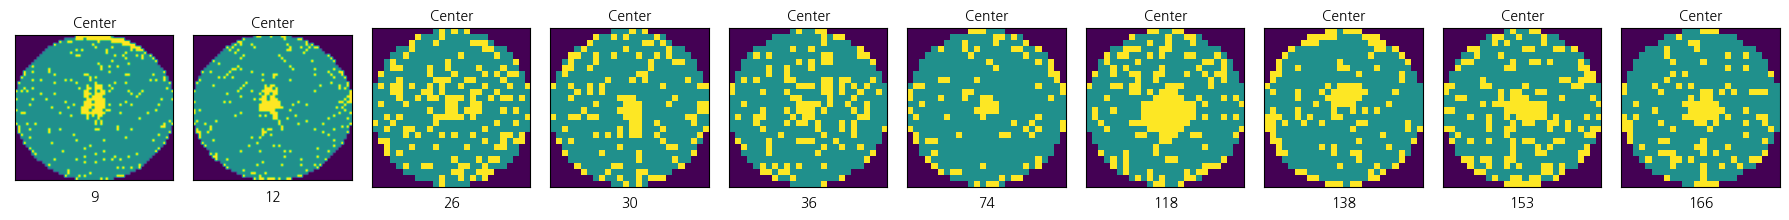

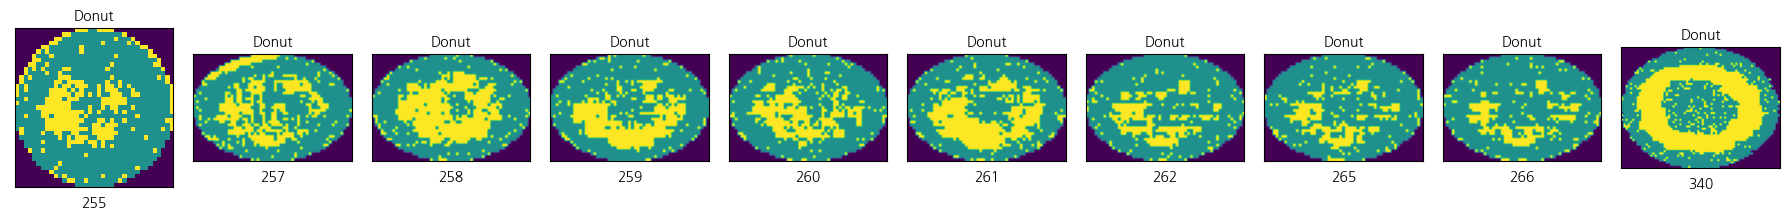

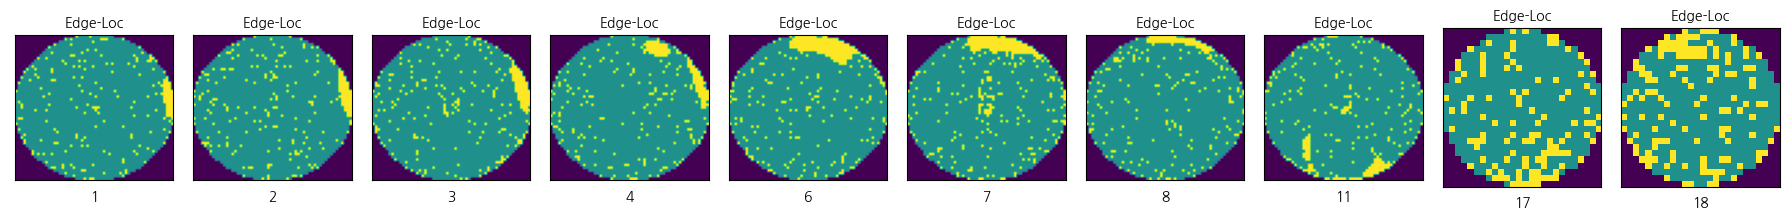

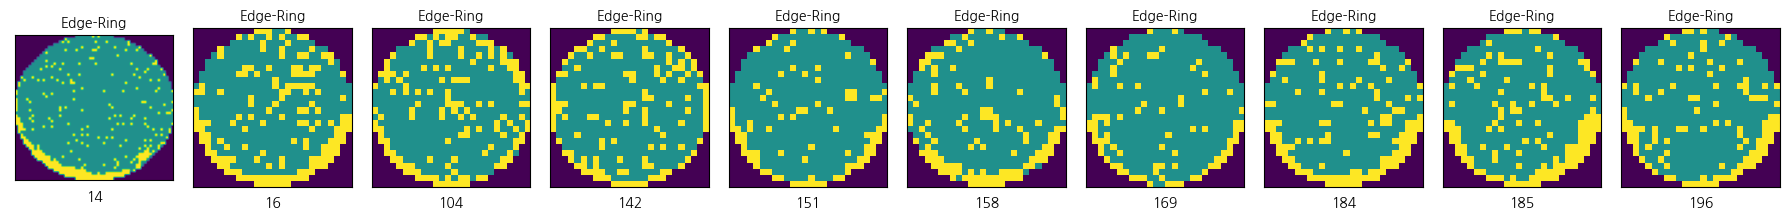

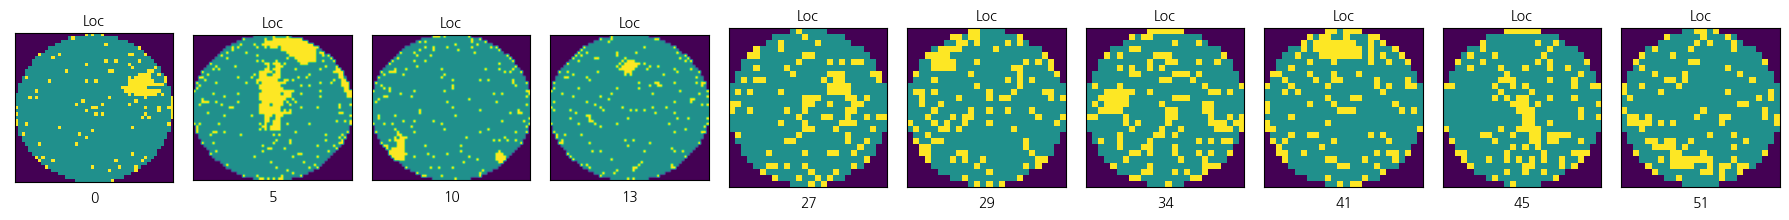

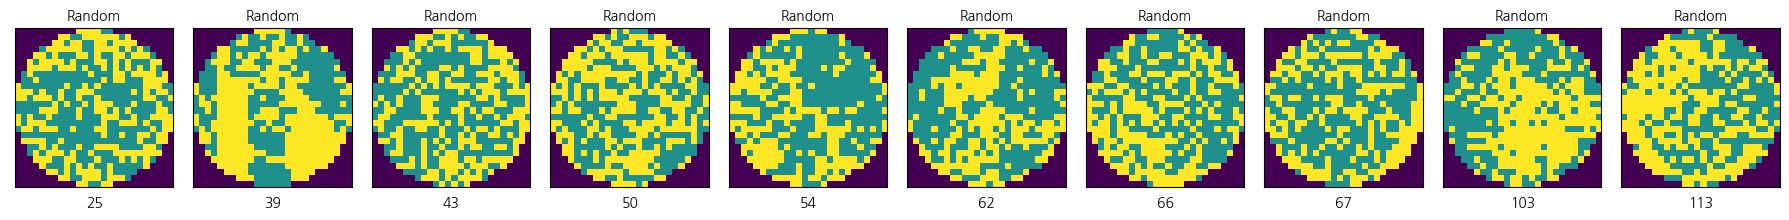

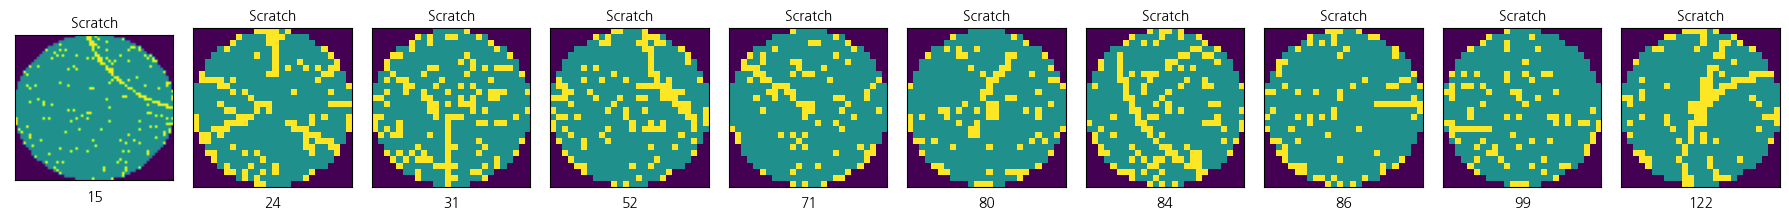

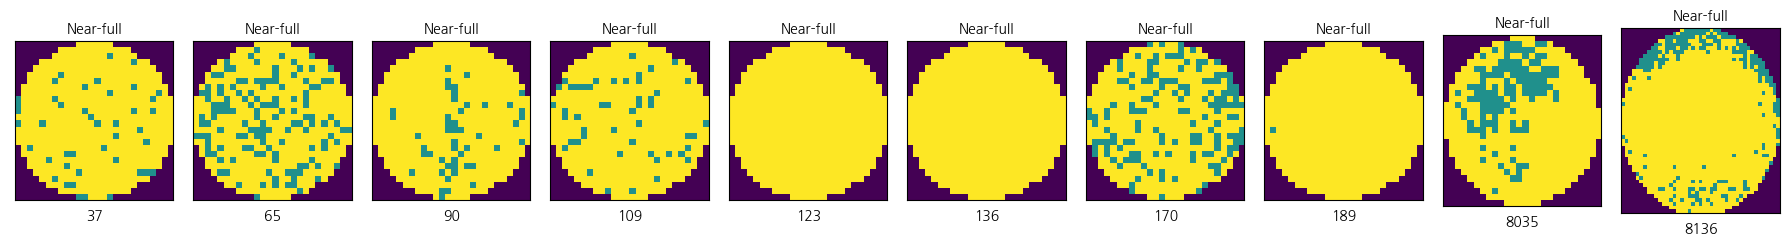

In [16]:
#불량 종류 시각화 - 3
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_label_values.waferMap[df_label_values.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_label_values.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df_label_values.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

In [17]:
df_wafermap.groupby('failureType')['failureType'].count()

failureType
Center         4294
Donut           555
Edge-Loc       5189
Edge-Ring      9680
Loc            3593
Near-full       149
Random          866
Scratch        1193
none         147431
Name: failureType, dtype: int64

In [18]:
#모델 구조를 좀더 자세히 보기위한 커스텀 Fuction
def custom_summary(model):
    print("Model: {}".format(model.name))
    print("Layers:")
    
    input_shape = model.layers[0].input_shape
    for i, layer in enumerate(model.layers):
        config = layer.get_config()
        output_shape = layer.output_shape
        
        layer_info = "  Layer {}: {} |".format(i, layer.__class__.__name__)
        
        if 'filters' in config:
            layer_info += " Filters: {} |".format(config['filters'])
        if 'kernel_size' in config:
            layer_info += " Filter size: {}x{} |".format(config['kernel_size'][0], config['kernel_size'][1])
        if 'padding' in config:
            layer_info += " Padding: {} |".format(config['padding'])
        if 'activation' in config:
            layer_info += " Activation: {} |".format(config['activation'])
            
        if isinstance(output_shape, list):
            output_shape = output_shape[0]
        
        layer_info += " Output shape: {}".format(output_shape)
        print(layer_info)
        
        input_shape = output_shape

In [19]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="wafermap_train",

    # track hyperparameters and run metadata with wandb.config
    config={
        "learning_rate": 0.001,
        "epoch": 100,
        "batch_size": 100
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hyunwoojang86 (euclidsoft). Use `wandb login --relogin` to force relogin


In [20]:
#전체 9가지 라벨 리스트
wf_train_labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full', 'none']
#논문에서 제안한 모델 파라미터를 그대로 적용함.
#논문에서는 224*224로 제언하였으나, VRAM 문제로 인하여 112*112로 줄여서 실험
model = Sequential([    
    # 이미지 처리 및 특징 추출 레이어    
    # Input
    Input(shape=(224, 224, 3)),
    
    # block 1
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),  
    
    # block 5
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),    
    
    
    SpatialDropout2D(rate=0.2),
    
    Flatten(),
    
    # 레이어 완전연결 및 출력 레이어 설정
    Dense(4608, activation='relu'),    
    Dropout(0.5),
    Dense(512, activation='relu'),    
    Dropout(0.5),
    Dense(9, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=config.learning_rate)
              , loss='categorical_crossentropy'
              , metrics=['accuracy'
                         , tf.keras.metrics.Recall()
                         , tf.keras.metrics.Precision()
                        , tensorflow_addons.metrics.F1Score(num_classes=len(wf_train_labels), average='macro')
                        ])
custom_summary(model)

Model: sequential
Layers:
  Layer 0: Conv2D | Filters: 16 | Filter size: 3x3 | Padding: valid | Activation: relu | Output shape: (None, 222, 222, 16)
  Layer 1: BatchNormalization | Output shape: (None, 222, 222, 16)
  Layer 2: MaxPooling2D | Padding: valid | Output shape: (None, 111, 111, 16)
  Layer 3: Conv2D | Filters: 16 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 111, 111, 16)
  Layer 4: Conv2D | Filters: 32 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 111, 111, 32)
  Layer 5: BatchNormalization | Output shape: (None, 111, 111, 32)
  Layer 6: MaxPooling2D | Padding: valid | Output shape: (None, 55, 55, 32)
  Layer 7: Conv2D | Filters: 32 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 55, 55, 32)
  Layer 8: Conv2D | Filters: 64 | Filter size: 3x3 | Padding: same | Activation: relu | Output shape: (None, 55, 55, 64)
  Layer 9: BatchNormalization | Output shape: (None, 55, 55, 64)
  Layer 1

In [21]:
#불량 이미지 저장을 위한 폴더 생성
for f_labels in wf_train_labels:
    if not os.path.exists(os.path.join('wafermap_images_no_aug', f_labels)):
        os.makedirs(os.path.join('wafermap_images_no_aug', f_labels))

In [22]:
#이미지 추출 및 파일 저장 함수
def image_write(rows):
    write_path = os.path.join('wafermap_images_no_aug', rows['failureType'], str(int(rows['index'])) + '.png')
    wafermap_rgb = np.zeros((rows['waferMap'].shape[0], rows['waferMap'].shape[1], 3), dtype=np.uint8)
    for i in range(rows['waferMap'].shape[0]):
        for j in range(rows['waferMap'].shape[1]):
            # wafermap의 각 값에 대한 RGB 색상 코드를 설정합니다.
            if rows['waferMap'][i, j] == 0:
                wafermap_rgb[i, j] = [82, 1, 74]  # 검정색 (배경)
            elif rows['waferMap'][i, j] == 1:
                wafermap_rgb[i, j] = [37, 231, 255]  # 노란색 (양품)
            else:
                wafermap_rgb[i, j] = [150, 144, 28]  # 초록색 (불량)
    cv2.cvtColor(wafermap_rgb, cv2.COLOR_BGR2RGB)
    cv2.imwrite(write_path, wafermap_rgb)

In [23]:
#이미지 추출 및 이미지 객체 리턴 함수
def image_return_wafermap(waferMap):
    wafermap_rgb = np.zeros((waferMap.shape[0], waferMap.shape[1], 3), dtype=np.uint8)
    for i in range(waferMap.shape[0]):
        for j in range(waferMap.shape[1]):
            # wafermap의 각 값에 대한 RGB 색상 코드를 설정합니다.
            if waferMap[i, j] == 0:
                wafermap_rgb[i, j] = [82, 1, 74]  # 검정색 (배경)
            elif waferMap[i, j] == 1:
                wafermap_rgb[i, j] = [37, 231, 255]  # 노란색 (양품)
            else:
                wafermap_rgb[i, j] = [150, 144, 28]  # 초록색 (불량)
    return wafermap_rgb

In [24]:
#최초 실행시 이미지 저장 실행(멀티 프로세싱 적용)
if is_first:
    df_wafermap.mapply(lambda x: image_write(x), axis=1)

In [25]:
none_size = int(len(df_wafermap[df_wafermap['failureType'] != 'none']) / 8)

In [49]:
#각 라벨링별 1만건 추출 작업
all_train_images = []
for idx, l in enumerate(wf_train_labels):
    image_directory = os.path.join('wafermap_images_no_aug', l)
    ims = [(os.path.join(image_directory, f), idx) for f in os.listdir(image_directory) if os.path.isfile(os.path.join(image_directory, f))]
    random.shuffle(ims)
    if l == 'none':
        ims = ims[:none_size]
    all_train_images.extend(ims)

In [27]:
pd.DataFrame(all_train_images, columns=['image_path', 'failureType']).groupby('failureType').count()

,image_path
failureType,
0,4294
1,555
2,5189
3,9680
4,3593
5,866
6,1193
7,149
8,3189


In [28]:
#train, val, test 데이터셋 추출(65 : 20 : 10)
train_files, test_files = train_test_split(all_train_images, test_size=0.35, random_state=42)
val_files, test_files = train_test_split(test_files, test_size=0.42, random_state=42)

In [29]:
print('train_data : ', len(train_files)
      , '\nvalidation_data : ', len(val_files)
      , '\ntest_data : ', len(test_files))

train_data :  18660 
validation_data :  5827 
test_data :  4221


In [30]:
#모델 선언시 언급한 문제로 입력 사이즈 112*112에 따라 이미지 리사즈하여 로드 처리
dsize = 224
def load_images_and_labels(files_list):
    images, labels = [], []
    for file, label in tqdm(files_list):
        img = cv2.imread(file)
        img = cv2.resize(img, (dsize, dsize))
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

In [31]:
#학습 데이터 로드
train_images, train_labels = load_images_and_labels(train_files)
val_images, val_labels = load_images_and_labels(val_files)
test_images, test_labels = load_images_and_labels(test_files)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4221/4221 [00:00<00:00, 15529.64it/s]


In [32]:
#라벨링 데이터 차원 변경
train_labels = to_categorical(train_labels, len(wf_train_labels))
val_labels = to_categorical(val_labels, len(wf_train_labels))
test_labels = to_categorical(test_labels, len(wf_train_labels))

In [33]:
with tf.device('CPU'):
    #데이터 메모리 선 적재를 위한 텐서 변경 및 분할 작업
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

In [34]:
batch_size = 100  #배치크기
buffer_size = 10000  # 버퍼크기
epochs = 100 #에폭
steps_per_epoch = len(train_images) // batch_size  # steps_per_epoch 계산
val_steps_per_epoch = len(val_images) // batch_size  # val_steps_per_epoch 계산

In [35]:
# 학습 데이터를 섞어 미리 메모리 적재(빠른 로딩을 위한 동적로드 적용)
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
# 검증 데이터를 섞어 미리 메모리 적재(빠른 로딩을 위한 동적로드 적용)
validation_dataset = validation_dataset.shuffle(buffer_size).batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)

In [37]:
#학습 진행
model_fit_history = None
model_fit_history = model.fit(train_dataset
                              , validation_data=validation_dataset
                              , validation_steps=val_steps_per_epoch
                              , epochs=epochs
                              , steps_per_epoch=steps_per_epoch
                             , callbacks=[WandbMetricsLogger(log_freq=5),
                                      WandbModelCheckpoint("models")
                                    ])

Epoch 1/100
186/186 [==============================] - ETA: 0s - loss: 1.3123 - accuracy: 0.6962 - recall: 0.5990 - precision: 0.8073 - f1_score: 0.5493

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 22s 99ms/step - loss: 1.3123 - accuracy: 0.6962 - recall: 0.5990 - precision: 0.8073 - f1_score: 0.5493 - val_loss: 1.3505 - val_accuracy: 0.6088 - val_recall: 0.2140 - val_precision: 0.9473 - val_f1_score: 0.4561
Epoch 2/100
186/186 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.8322 - recall: 0.7875 - precision: 0.8783 - f1_score: 0.7191

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.5129 - accuracy: 0.8322 - recall: 0.7875 - precision: 0.8783 - f1_score: 0.7191 - val_loss: 0.3994 - val_accuracy: 0.8491 - val_recall: 0.8126 - val_precision: 0.8958 - val_f1_score: 0.7442
Epoch 3/100
186/186 [==============================] - ETA: 0s - loss: 0.4163 - accuracy: 0.8598 - recall: 0.8257 - precision: 0.8957 - f1_score: 0.7667

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 93ms/step - loss: 0.4163 - accuracy: 0.8598 - recall: 0.8257 - precision: 0.8957 - f1_score: 0.7667 - val_loss: 0.4388 - val_accuracy: 0.8350 - val_recall: 0.7929 - val_precision: 0.8692 - val_f1_score: 0.7859
Epoch 4/100
186/186 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8836 - recall: 0.8579 - precision: 0.9103 - f1_score: 0.8133

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 94ms/step - loss: 0.3439 - accuracy: 0.8836 - recall: 0.8579 - precision: 0.9103 - f1_score: 0.8133 - val_loss: 0.3520 - val_accuracy: 0.8776 - val_recall: 0.8645 - val_precision: 0.8987 - val_f1_score: 0.7892
Epoch 5/100
186/186 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8978 - recall: 0.8794 - precision: 0.9195 - f1_score: 0.8414

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 97ms/step - loss: 0.2984 - accuracy: 0.8978 - recall: 0.8794 - precision: 0.9195 - f1_score: 0.8414 - val_loss: 0.3241 - val_accuracy: 0.8905 - val_recall: 0.8771 - val_precision: 0.9056 - val_f1_score: 0.8361
Epoch 6/100
186/186 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.9122 - recall: 0.8969 - precision: 0.9285 - f1_score: 0.8693

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.2607 - accuracy: 0.9122 - recall: 0.8969 - precision: 0.9285 - f1_score: 0.8693 - val_loss: 0.5615 - val_accuracy: 0.8022 - val_recall: 0.7752 - val_precision: 0.8451 - val_f1_score: 0.7262
Epoch 7/100
186/186 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9191 - recall: 0.9037 - precision: 0.9336 - f1_score: 0.8774

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 94ms/step - loss: 0.2474 - accuracy: 0.9191 - recall: 0.9037 - precision: 0.9336 - f1_score: 0.8774 - val_loss: 0.5038 - val_accuracy: 0.8391 - val_recall: 0.8217 - val_precision: 0.8648 - val_f1_score: 0.7993
Epoch 8/100
186/186 [==============================] - ETA: 0s - loss: 0.2198 - accuracy: 0.9246 - recall: 0.9137 - precision: 0.9377 - f1_score: 0.8851

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 94ms/step - loss: 0.2198 - accuracy: 0.9246 - recall: 0.9137 - precision: 0.9377 - f1_score: 0.8851 - val_loss: 0.2853 - val_accuracy: 0.9062 - val_recall: 0.8910 - val_precision: 0.9209 - val_f1_score: 0.8718
Epoch 9/100
186/186 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9320 - recall: 0.9209 - precision: 0.9432 - f1_score: 0.9003

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 97ms/step - loss: 0.2023 - accuracy: 0.9320 - recall: 0.9209 - precision: 0.9432 - f1_score: 0.9003 - val_loss: 0.4308 - val_accuracy: 0.8769 - val_recall: 0.8650 - val_precision: 0.8903 - val_f1_score: 0.8225
Epoch 10/100
186/186 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9386 - recall: 0.9283 - precision: 0.9476 - f1_score: 0.9122

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.1939 - accuracy: 0.9386 - recall: 0.9283 - precision: 0.9476 - f1_score: 0.9122 - val_loss: 0.2822 - val_accuracy: 0.9050 - val_recall: 0.8872 - val_precision: 0.9284 - val_f1_score: 0.8734
Epoch 11/100
186/186 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9325 - recall: 0.9230 - precision: 0.9432 - f1_score: 0.9041

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 94ms/step - loss: 0.2090 - accuracy: 0.9325 - recall: 0.9230 - precision: 0.9432 - f1_score: 0.9041 - val_loss: 0.2683 - val_accuracy: 0.9153 - val_recall: 0.8993 - val_precision: 0.9313 - val_f1_score: 0.8867
Epoch 12/100
186/186 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9481 - recall: 0.9419 - precision: 0.9551 - f1_score: 0.9195

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.1535 - accuracy: 0.9481 - recall: 0.9419 - precision: 0.9551 - f1_score: 0.9195 - val_loss: 0.3275 - val_accuracy: 0.9083 - val_recall: 0.9033 - val_precision: 0.9157 - val_f1_score: 0.8600
Epoch 13/100
186/186 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9543 - recall: 0.9490 - precision: 0.9602 - f1_score: 0.9293

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.1367 - accuracy: 0.9543 - recall: 0.9490 - precision: 0.9602 - f1_score: 0.9293 - val_loss: 0.2963 - val_accuracy: 0.9164 - val_recall: 0.9098 - val_precision: 0.9235 - val_f1_score: 0.8834
Epoch 14/100
186/186 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9573 - recall: 0.9524 - precision: 0.9625 - f1_score: 0.9355

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 94ms/step - loss: 0.1360 - accuracy: 0.9573 - recall: 0.9524 - precision: 0.9625 - f1_score: 0.9355 - val_loss: 0.3466 - val_accuracy: 0.9067 - val_recall: 0.9036 - val_precision: 0.9123 - val_f1_score: 0.8637
Epoch 15/100
186/186 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9621 - recall: 0.9580 - precision: 0.9660 - f1_score: 0.9440

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 97ms/step - loss: 0.1160 - accuracy: 0.9621 - recall: 0.9580 - precision: 0.9660 - f1_score: 0.9440 - val_loss: 0.5199 - val_accuracy: 0.8686 - val_recall: 0.8605 - val_precision: 0.8790 - val_f1_score: 0.8290
Epoch 16/100
186/186 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9648 - recall: 0.9615 - precision: 0.9689 - f1_score: 0.9527

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 22s 121ms/step - loss: 0.1080 - accuracy: 0.9648 - recall: 0.9615 - precision: 0.9689 - f1_score: 0.9527 - val_loss: 0.3537 - val_accuracy: 0.9160 - val_recall: 0.9140 - val_precision: 0.9214 - val_f1_score: 0.8774
Epoch 17/100
186/186 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9685 - recall: 0.9664 - precision: 0.9718 - f1_score: 0.9498

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0948 - accuracy: 0.9685 - recall: 0.9664 - precision: 0.9718 - f1_score: 0.9498 - val_loss: 0.7819 - val_accuracy: 0.8524 - val_recall: 0.8498 - val_precision: 0.8565 - val_f1_score: 0.8219
Epoch 18/100
186/186 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9724 - recall: 0.9695 - precision: 0.9744 - f1_score: 0.9608

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 97ms/step - loss: 0.0880 - accuracy: 0.9724 - recall: 0.9695 - precision: 0.9744 - f1_score: 0.9608 - val_loss: 0.3616 - val_accuracy: 0.9036 - val_recall: 0.8979 - val_precision: 0.9137 - val_f1_score: 0.8679
Epoch 19/100
186/186 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9652 - recall: 0.9613 - precision: 0.9697 - f1_score: 0.9473

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.1099 - accuracy: 0.9652 - recall: 0.9613 - precision: 0.9697 - f1_score: 0.9473 - val_loss: 0.3240 - val_accuracy: 0.9172 - val_recall: 0.9124 - val_precision: 0.9249 - val_f1_score: 0.8742
Epoch 20/100
186/186 [==============================] - ETA: 0s - loss: 0.0843 - accuracy: 0.9724 - recall: 0.9693 - precision: 0.9756 - f1_score: 0.9575

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0843 - accuracy: 0.9724 - recall: 0.9693 - precision: 0.9756 - f1_score: 0.9575 - val_loss: 0.4365 - val_accuracy: 0.9098 - val_recall: 0.9069 - val_precision: 0.9154 - val_f1_score: 0.8777
Epoch 21/100
186/186 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9755 - recall: 0.9737 - precision: 0.9777 - f1_score: 0.9650

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 98ms/step - loss: 0.0779 - accuracy: 0.9755 - recall: 0.9737 - precision: 0.9777 - f1_score: 0.9650 - val_loss: 0.4815 - val_accuracy: 0.9031 - val_recall: 0.9007 - val_precision: 0.9047 - val_f1_score: 0.8516
Epoch 22/100
186/186 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9773 - recall: 0.9752 - precision: 0.9786 - f1_score: 0.9667

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0750 - accuracy: 0.9773 - recall: 0.9752 - precision: 0.9786 - f1_score: 0.9667 - val_loss: 0.3829 - val_accuracy: 0.9203 - val_recall: 0.9176 - val_precision: 0.9243 - val_f1_score: 0.8894
Epoch 23/100
186/186 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9761 - recall: 0.9744 - precision: 0.9786 - f1_score: 0.9621

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0809 - accuracy: 0.9761 - recall: 0.9744 - precision: 0.9786 - f1_score: 0.9621 - val_loss: 0.4306 - val_accuracy: 0.9071 - val_recall: 0.9043 - val_precision: 0.9107 - val_f1_score: 0.8743
Epoch 24/100
186/186 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9764 - recall: 0.9747 - precision: 0.9779 - f1_score: 0.9658

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0743 - accuracy: 0.9764 - recall: 0.9747 - precision: 0.9779 - f1_score: 0.9658 - val_loss: 1.0369 - val_accuracy: 0.8448 - val_recall: 0.8419 - val_precision: 0.8485 - val_f1_score: 0.8097
Epoch 25/100
186/186 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9798 - recall: 0.9788 - precision: 0.9811 - f1_score: 0.9732

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0675 - accuracy: 0.9798 - recall: 0.9788 - precision: 0.9811 - f1_score: 0.9732 - val_loss: 0.4247 - val_accuracy: 0.9083 - val_recall: 0.9048 - val_precision: 0.9144 - val_f1_score: 0.8726
Epoch 26/100
186/186 [==============================] - ETA: 0s - loss: 0.0706 - accuracy: 0.9794 - recall: 0.9777 - precision: 0.9810 - f1_score: 0.9692

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 25s 133ms/step - loss: 0.0706 - accuracy: 0.9794 - recall: 0.9777 - precision: 0.9810 - f1_score: 0.9692 - val_loss: 0.4307 - val_accuracy: 0.9090 - val_recall: 0.9066 - val_precision: 0.9133 - val_f1_score: 0.8786
Epoch 27/100
186/186 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9853 - recall: 0.9844 - precision: 0.9863 - f1_score: 0.9759

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 18s 97ms/step - loss: 0.0503 - accuracy: 0.9853 - recall: 0.9844 - precision: 0.9863 - f1_score: 0.9759 - val_loss: 0.4499 - val_accuracy: 0.9088 - val_recall: 0.9071 - val_precision: 0.9127 - val_f1_score: 0.8812
Epoch 28/100
186/186 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9819 - recall: 0.9810 - precision: 0.9838 - f1_score: 0.9721

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 93ms/step - loss: 0.0638 - accuracy: 0.9819 - recall: 0.9810 - precision: 0.9838 - f1_score: 0.9721 - val_loss: 0.5998 - val_accuracy: 0.8760 - val_recall: 0.8690 - val_precision: 0.8837 - val_f1_score: 0.8374
Epoch 29/100
186/186 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9843 - recall: 0.9834 - precision: 0.9853 - f1_score: 0.9792

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0521 - accuracy: 0.9843 - recall: 0.9834 - precision: 0.9853 - f1_score: 0.9792 - val_loss: 0.4607 - val_accuracy: 0.9140 - val_recall: 0.9119 - val_precision: 0.9195 - val_f1_score: 0.8877
Epoch 30/100
186/186 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9865 - recall: 0.9858 - precision: 0.9871 - f1_score: 0.9789

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0460 - accuracy: 0.9865 - recall: 0.9858 - precision: 0.9871 - f1_score: 0.9789 - val_loss: 0.4486 - val_accuracy: 0.9086 - val_recall: 0.9060 - val_precision: 0.9128 - val_f1_score: 0.8812
Epoch 31/100
186/186 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9849 - recall: 0.9841 - precision: 0.9856 - f1_score: 0.9781

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 94ms/step - loss: 0.0540 - accuracy: 0.9849 - recall: 0.9841 - precision: 0.9856 - f1_score: 0.9781 - val_loss: 0.4130 - val_accuracy: 0.9207 - val_recall: 0.9179 - val_precision: 0.9240 - val_f1_score: 0.8977
Epoch 32/100
186/186 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9834 - recall: 0.9822 - precision: 0.9842 - f1_score: 0.9763

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0593 - accuracy: 0.9834 - recall: 0.9822 - precision: 0.9842 - f1_score: 0.9763 - val_loss: 0.4073 - val_accuracy: 0.9133 - val_recall: 0.9098 - val_precision: 0.9168 - val_f1_score: 0.8813
Epoch 33/100
186/186 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9853 - recall: 0.9841 - precision: 0.9861 - f1_score: 0.9757

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0584 - accuracy: 0.9853 - recall: 0.9841 - precision: 0.9861 - f1_score: 0.9757 - val_loss: 0.7315 - val_accuracy: 0.8864 - val_recall: 0.8848 - val_precision: 0.8896 - val_f1_score: 0.8499
Epoch 34/100
186/186 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9841 - recall: 0.9832 - precision: 0.9852 - f1_score: 0.9778

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 18s 95ms/step - loss: 0.0534 - accuracy: 0.9841 - recall: 0.9832 - precision: 0.9852 - f1_score: 0.9778 - val_loss: 0.4329 - val_accuracy: 0.9217 - val_recall: 0.9193 - val_precision: 0.9249 - val_f1_score: 0.8948
Epoch 35/100
186/186 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9869 - recall: 0.9863 - precision: 0.9877 - f1_score: 0.9808

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0485 - accuracy: 0.9869 - recall: 0.9863 - precision: 0.9877 - f1_score: 0.9808 - val_loss: 0.4785 - val_accuracy: 0.9226 - val_recall: 0.9203 - val_precision: 0.9250 - val_f1_score: 0.8904
Epoch 36/100
186/186 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9869 - recall: 0.9861 - precision: 0.9877 - f1_score: 0.9795

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 94ms/step - loss: 0.0469 - accuracy: 0.9869 - recall: 0.9861 - precision: 0.9877 - f1_score: 0.9795 - val_loss: 0.4569 - val_accuracy: 0.9159 - val_recall: 0.9134 - val_precision: 0.9182 - val_f1_score: 0.8906
Epoch 37/100
186/186 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9892 - recall: 0.9886 - precision: 0.9896 - f1_score: 0.9864

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0404 - accuracy: 0.9892 - recall: 0.9886 - precision: 0.9896 - f1_score: 0.9864 - val_loss: 0.4483 - val_accuracy: 0.9103 - val_recall: 0.9072 - val_precision: 0.9161 - val_f1_score: 0.8717
Epoch 38/100
186/186 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9885 - recall: 0.9875 - precision: 0.9895 - f1_score: 0.9825

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 94ms/step - loss: 0.0403 - accuracy: 0.9885 - recall: 0.9875 - precision: 0.9895 - f1_score: 0.9825 - val_loss: 0.6899 - val_accuracy: 0.9114 - val_recall: 0.9109 - val_precision: 0.9137 - val_f1_score: 0.8707
Epoch 39/100
186/186 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9849 - recall: 0.9841 - precision: 0.9861 - f1_score: 0.9768

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 94ms/step - loss: 0.0583 - accuracy: 0.9849 - recall: 0.9841 - precision: 0.9861 - f1_score: 0.9768 - val_loss: 0.3739 - val_accuracy: 0.9171 - val_recall: 0.9131 - val_precision: 0.9233 - val_f1_score: 0.8843
Epoch 40/100
186/186 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9875 - recall: 0.9869 - precision: 0.9882 - f1_score: 0.9821

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 97ms/step - loss: 0.0482 - accuracy: 0.9875 - recall: 0.9869 - precision: 0.9882 - f1_score: 0.9821 - val_loss: 0.4390 - val_accuracy: 0.9174 - val_recall: 0.9147 - val_precision: 0.9202 - val_f1_score: 0.8896
Epoch 41/100
186/186 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9913 - recall: 0.9907 - precision: 0.9916 - f1_score: 0.9851

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0318 - accuracy: 0.9913 - recall: 0.9907 - precision: 0.9916 - f1_score: 0.9851 - val_loss: 0.8520 - val_accuracy: 0.8950 - val_recall: 0.8936 - val_precision: 0.8975 - val_f1_score: 0.8143
Epoch 42/100
186/186 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9889 - recall: 0.9885 - precision: 0.9892 - f1_score: 0.9840

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 94ms/step - loss: 0.0397 - accuracy: 0.9889 - recall: 0.9885 - precision: 0.9892 - f1_score: 0.9840 - val_loss: 0.5167 - val_accuracy: 0.9174 - val_recall: 0.9159 - val_precision: 0.9203 - val_f1_score: 0.8878
Epoch 43/100
186/186 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9835 - recall: 0.9822 - precision: 0.9850 - f1_score: 0.9779

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 96ms/step - loss: 0.0627 - accuracy: 0.9835 - recall: 0.9822 - precision: 0.9850 - f1_score: 0.9779 - val_loss: 0.4443 - val_accuracy: 0.9029 - val_recall: 0.8990 - val_precision: 0.9106 - val_f1_score: 0.8692
Epoch 44/100
186/186 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9899 - recall: 0.9890 - precision: 0.9904 - f1_score: 0.9848

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0391 - accuracy: 0.9899 - recall: 0.9890 - precision: 0.9904 - f1_score: 0.9848 - val_loss: 0.5221 - val_accuracy: 0.9212 - val_recall: 0.9198 - val_precision: 0.9240 - val_f1_score: 0.8983
Epoch 45/100
186/186 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9872 - recall: 0.9866 - precision: 0.9881 - f1_score: 0.9825

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0448 - accuracy: 0.9872 - recall: 0.9866 - precision: 0.9881 - f1_score: 0.9825 - val_loss: 0.4556 - val_accuracy: 0.9164 - val_recall: 0.9134 - val_precision: 0.9204 - val_f1_score: 0.8834
Epoch 46/100
186/186 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9914 - recall: 0.9909 - precision: 0.9919 - f1_score: 0.9815

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 97ms/step - loss: 0.0329 - accuracy: 0.9914 - recall: 0.9909 - precision: 0.9919 - f1_score: 0.9815 - val_loss: 0.6173 - val_accuracy: 0.9040 - val_recall: 0.9021 - val_precision: 0.9058 - val_f1_score: 0.8691
Epoch 47/100
186/186 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9919 - recall: 0.9915 - precision: 0.9922 - f1_score: 0.9859

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 95ms/step - loss: 0.0309 - accuracy: 0.9919 - recall: 0.9915 - precision: 0.9922 - f1_score: 0.9859 - val_loss: 0.4462 - val_accuracy: 0.9167 - val_recall: 0.9148 - val_precision: 0.9201 - val_f1_score: 0.8834
Epoch 48/100
186/186 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9922 - recall: 0.9920 - precision: 0.9925 - f1_score: 0.9885

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 93ms/step - loss: 0.0285 - accuracy: 0.9922 - recall: 0.9920 - precision: 0.9925 - f1_score: 0.9885 - val_loss: 0.5184 - val_accuracy: 0.9117 - val_recall: 0.9093 - val_precision: 0.9159 - val_f1_score: 0.8781
Epoch 49/100
186/186 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9906 - recall: 0.9902 - precision: 0.9910 - f1_score: 0.9873

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 18s 97ms/step - loss: 0.0352 - accuracy: 0.9906 - recall: 0.9902 - precision: 0.9910 - f1_score: 0.9873 - val_loss: 0.4419 - val_accuracy: 0.9179 - val_recall: 0.9143 - val_precision: 0.9245 - val_f1_score: 0.8937
Epoch 50/100
186/186 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9898 - recall: 0.9894 - precision: 0.9905 - f1_score: 0.9876

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 93ms/step - loss: 0.0343 - accuracy: 0.9898 - recall: 0.9894 - precision: 0.9905 - f1_score: 0.9876 - val_loss: 0.5751 - val_accuracy: 0.9122 - val_recall: 0.9093 - val_precision: 0.9150 - val_f1_score: 0.8730
Epoch 51/100
186/186 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9920 - recall: 0.9915 - precision: 0.9927 - f1_score: 0.9870

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0331 - accuracy: 0.9920 - recall: 0.9915 - precision: 0.9927 - f1_score: 0.9870 - val_loss: 0.4284 - val_accuracy: 0.9234 - val_recall: 0.9203 - val_precision: 0.9277 - val_f1_score: 0.8898
Epoch 52/100
186/186 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9917 - recall: 0.9911 - precision: 0.9922 - f1_score: 0.9872

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0284 - accuracy: 0.9917 - recall: 0.9911 - precision: 0.9922 - f1_score: 0.9872 - val_loss: 0.6133 - val_accuracy: 0.9116 - val_recall: 0.9098 - val_precision: 0.9160 - val_f1_score: 0.8795
Epoch 53/100
186/186 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9904 - recall: 0.9895 - precision: 0.9906 - f1_score: 0.9823

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0477 - accuracy: 0.9904 - recall: 0.9895 - precision: 0.9906 - f1_score: 0.9823 - val_loss: 0.7484 - val_accuracy: 0.8907 - val_recall: 0.8898 - val_precision: 0.8951 - val_f1_score: 0.8515
Epoch 54/100
186/186 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9925 - recall: 0.9920 - precision: 0.9929 - f1_score: 0.9888

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0278 - accuracy: 0.9925 - recall: 0.9920 - precision: 0.9929 - f1_score: 0.9888 - val_loss: 0.6321 - val_accuracy: 0.9021 - val_recall: 0.8991 - val_precision: 0.9062 - val_f1_score: 0.8655
Epoch 55/100
186/186 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9917 - recall: 0.9912 - precision: 0.9926 - f1_score: 0.9898

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0314 - accuracy: 0.9917 - recall: 0.9912 - precision: 0.9926 - f1_score: 0.9898 - val_loss: 0.5793 - val_accuracy: 0.9059 - val_recall: 0.9007 - val_precision: 0.9107 - val_f1_score: 0.8686
Epoch 56/100
186/186 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9912 - recall: 0.9906 - precision: 0.9917 - f1_score: 0.9854

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 92ms/step - loss: 0.0345 - accuracy: 0.9912 - recall: 0.9906 - precision: 0.9917 - f1_score: 0.9854 - val_loss: 0.7454 - val_accuracy: 0.8941 - val_recall: 0.8924 - val_precision: 0.8971 - val_f1_score: 0.8493
Epoch 57/100
186/186 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9923 - recall: 0.9921 - precision: 0.9926 - f1_score: 0.9888

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 91ms/step - loss: 0.0268 - accuracy: 0.9923 - recall: 0.9921 - precision: 0.9926 - f1_score: 0.9888 - val_loss: 0.5744 - val_accuracy: 0.9193 - val_recall: 0.9167 - val_precision: 0.9234 - val_f1_score: 0.8935
Epoch 58/100
186/186 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9913 - recall: 0.9904 - precision: 0.9917 - f1_score: 0.9863

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0411 - accuracy: 0.9913 - recall: 0.9904 - precision: 0.9917 - f1_score: 0.9863 - val_loss: 0.6138 - val_accuracy: 0.8929 - val_recall: 0.8902 - val_precision: 0.8981 - val_f1_score: 0.8665
Epoch 59/100
186/186 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9925 - recall: 0.9920 - precision: 0.9930 - f1_score: 0.9895

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0258 - accuracy: 0.9925 - recall: 0.9920 - precision: 0.9930 - f1_score: 0.9895 - val_loss: 0.4671 - val_accuracy: 0.9169 - val_recall: 0.9150 - val_precision: 0.9220 - val_f1_score: 0.8864
Epoch 60/100
186/186 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9933 - recall: 0.9933 - precision: 0.9940 - f1_score: 0.9885

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0286 - accuracy: 0.9933 - recall: 0.9933 - precision: 0.9940 - f1_score: 0.9885 - val_loss: 0.6322 - val_accuracy: 0.8898 - val_recall: 0.8876 - val_precision: 0.8956 - val_f1_score: 0.8587
Epoch 61/100
186/186 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9879 - recall: 0.9874 - precision: 0.9888 - f1_score: 0.9820

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0516 - accuracy: 0.9879 - recall: 0.9874 - precision: 0.9888 - f1_score: 0.9820 - val_loss: 0.5555 - val_accuracy: 0.9034 - val_recall: 0.9009 - val_precision: 0.9076 - val_f1_score: 0.8664
Epoch 62/100
186/186 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9915 - recall: 0.9914 - precision: 0.9919 - f1_score: 0.9859

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0293 - accuracy: 0.9915 - recall: 0.9914 - precision: 0.9919 - f1_score: 0.9859 - val_loss: 0.6379 - val_accuracy: 0.9057 - val_recall: 0.9031 - val_precision: 0.9087 - val_f1_score: 0.8703
Epoch 63/100
186/186 [==============================] - ETA: 0s - loss: 0.0298 - accuracy: 0.9929 - recall: 0.9927 - precision: 0.9934 - f1_score: 0.9881

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0298 - accuracy: 0.9929 - recall: 0.9927 - precision: 0.9934 - f1_score: 0.9881 - val_loss: 0.5546 - val_accuracy: 0.9171 - val_recall: 0.9160 - val_precision: 0.9190 - val_f1_score: 0.8859
Epoch 64/100
186/186 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9946 - recall: 0.9943 - precision: 0.9950 - f1_score: 0.9928

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 91ms/step - loss: 0.0197 - accuracy: 0.9946 - recall: 0.9943 - precision: 0.9950 - f1_score: 0.9928 - val_loss: 0.5892 - val_accuracy: 0.9105 - val_recall: 0.9086 - val_precision: 0.9145 - val_f1_score: 0.8841
Epoch 65/100
186/186 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9930 - recall: 0.9928 - precision: 0.9932 - f1_score: 0.9904

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0248 - accuracy: 0.9930 - recall: 0.9928 - precision: 0.9932 - f1_score: 0.9904 - val_loss: 0.7062 - val_accuracy: 0.9129 - val_recall: 0.9119 - val_precision: 0.9141 - val_f1_score: 0.8802
Epoch 66/100
186/186 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9940 - recall: 0.9936 - precision: 0.9943 - f1_score: 0.9913

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0216 - accuracy: 0.9940 - recall: 0.9936 - precision: 0.9943 - f1_score: 0.9913 - val_loss: 0.6862 - val_accuracy: 0.9141 - val_recall: 0.9128 - val_precision: 0.9164 - val_f1_score: 0.8793
Epoch 67/100
186/186 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9909 - recall: 0.9904 - precision: 0.9916 - f1_score: 0.9874

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 21s 111ms/step - loss: 0.0379 - accuracy: 0.9909 - recall: 0.9904 - precision: 0.9916 - f1_score: 0.9874 - val_loss: 0.9481 - val_accuracy: 0.8607 - val_recall: 0.8590 - val_precision: 0.8642 - val_f1_score: 0.8271
Epoch 68/100
186/186 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9895 - recall: 0.9890 - precision: 0.9900 - f1_score: 0.9848

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 91ms/step - loss: 0.0491 - accuracy: 0.9895 - recall: 0.9890 - precision: 0.9900 - f1_score: 0.9848 - val_loss: 1.1366 - val_accuracy: 0.8467 - val_recall: 0.8447 - val_precision: 0.8502 - val_f1_score: 0.8119
Epoch 69/100
186/186 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9920 - recall: 0.9913 - precision: 0.9924 - f1_score: 0.9881

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 90ms/step - loss: 0.0330 - accuracy: 0.9920 - recall: 0.9913 - precision: 0.9924 - f1_score: 0.9881 - val_loss: 0.5014 - val_accuracy: 0.9202 - val_recall: 0.9183 - val_precision: 0.9234 - val_f1_score: 0.8927
Epoch 70/100
186/186 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9923 - recall: 0.9920 - precision: 0.9928 - f1_score: 0.9904

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0307 - accuracy: 0.9923 - recall: 0.9920 - precision: 0.9928 - f1_score: 0.9904 - val_loss: 0.6208 - val_accuracy: 0.9197 - val_recall: 0.9181 - val_precision: 0.9213 - val_f1_score: 0.8925
Epoch 71/100
186/186 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9927 - recall: 0.9925 - precision: 0.9928 - f1_score: 0.9880

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0293 - accuracy: 0.9927 - recall: 0.9925 - precision: 0.9928 - f1_score: 0.9880 - val_loss: 0.5565 - val_accuracy: 0.9057 - val_recall: 0.9022 - val_precision: 0.9101 - val_f1_score: 0.8784
Epoch 72/100
186/186 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9940 - recall: 0.9936 - precision: 0.9943 - f1_score: 0.9917

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0217 - accuracy: 0.9940 - recall: 0.9936 - precision: 0.9943 - f1_score: 0.9917 - val_loss: 0.5419 - val_accuracy: 0.9095 - val_recall: 0.9072 - val_precision: 0.9164 - val_f1_score: 0.8784
Epoch 73/100
186/186 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9956 - recall: 0.9955 - precision: 0.9957 - f1_score: 0.9933

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0193 - accuracy: 0.9956 - recall: 0.9955 - precision: 0.9957 - f1_score: 0.9933 - val_loss: 0.5560 - val_accuracy: 0.9107 - val_recall: 0.9072 - val_precision: 0.9143 - val_f1_score: 0.8768
Epoch 74/100
186/186 [==============================] - ETA: 0s - loss: 0.0284 - accuracy: 0.9932 - recall: 0.9928 - precision: 0.9934 - f1_score: 0.9876

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0284 - accuracy: 0.9932 - recall: 0.9928 - precision: 0.9934 - f1_score: 0.9876 - val_loss: 0.6448 - val_accuracy: 0.9133 - val_recall: 0.9112 - val_precision: 0.9152 - val_f1_score: 0.8840
Epoch 75/100
186/186 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9952 - recall: 0.9951 - precision: 0.9955 - f1_score: 0.9934

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0180 - accuracy: 0.9952 - recall: 0.9951 - precision: 0.9955 - f1_score: 0.9934 - val_loss: 0.8652 - val_accuracy: 0.8993 - val_recall: 0.8979 - val_precision: 0.9012 - val_f1_score: 0.8713
Epoch 76/100
186/186 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9947 - recall: 0.9945 - precision: 0.9948 - f1_score: 0.9908

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0221 - accuracy: 0.9947 - recall: 0.9945 - precision: 0.9948 - f1_score: 0.9908 - val_loss: 0.5916 - val_accuracy: 0.9107 - val_recall: 0.9081 - val_precision: 0.9139 - val_f1_score: 0.8734
Epoch 77/100
186/186 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9928 - recall: 0.9927 - precision: 0.9932 - f1_score: 0.9877

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0314 - accuracy: 0.9928 - recall: 0.9927 - precision: 0.9932 - f1_score: 0.9877 - val_loss: 0.5625 - val_accuracy: 0.9122 - val_recall: 0.9081 - val_precision: 0.9168 - val_f1_score: 0.8832
Epoch 78/100
186/186 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9948 - recall: 0.9947 - precision: 0.9951 - f1_score: 0.9942

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0163 - accuracy: 0.9948 - recall: 0.9947 - precision: 0.9951 - f1_score: 0.9942 - val_loss: 0.8221 - val_accuracy: 0.9048 - val_recall: 0.9029 - val_precision: 0.9064 - val_f1_score: 0.8642
Epoch 79/100
186/186 [==============================] - ETA: 0s - loss: 0.0407 - accuracy: 0.9915 - recall: 0.9912 - precision: 0.9923 - f1_score: 0.9837

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0407 - accuracy: 0.9915 - recall: 0.9912 - precision: 0.9923 - f1_score: 0.9837 - val_loss: 0.6389 - val_accuracy: 0.9105 - val_recall: 0.9090 - val_precision: 0.9145 - val_f1_score: 0.8737
Epoch 80/100
186/186 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9909 - recall: 0.9906 - precision: 0.9913 - f1_score: 0.9848

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 90ms/step - loss: 0.0353 - accuracy: 0.9909 - recall: 0.9906 - precision: 0.9913 - f1_score: 0.9848 - val_loss: 0.6257 - val_accuracy: 0.9143 - val_recall: 0.9131 - val_precision: 0.9175 - val_f1_score: 0.8805
Epoch 81/100
186/186 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9948 - recall: 0.9947 - precision: 0.9950 - f1_score: 0.9925

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0197 - accuracy: 0.9948 - recall: 0.9947 - precision: 0.9950 - f1_score: 0.9925 - val_loss: 0.5994 - val_accuracy: 0.9131 - val_recall: 0.9102 - val_precision: 0.9162 - val_f1_score: 0.8818
Epoch 82/100
186/186 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9953 - recall: 0.9952 - precision: 0.9953 - f1_score: 0.9922

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0175 - accuracy: 0.9953 - recall: 0.9952 - precision: 0.9953 - f1_score: 0.9922 - val_loss: 0.6523 - val_accuracy: 0.9159 - val_recall: 0.9138 - val_precision: 0.9184 - val_f1_score: 0.8859
Epoch 83/100
186/186 [==============================] - ETA: 0s - loss: 0.0508 - accuracy: 0.9927 - recall: 0.9921 - precision: 0.9930 - f1_score: 0.9916

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0508 - accuracy: 0.9927 - recall: 0.9921 - precision: 0.9930 - f1_score: 0.9916 - val_loss: 0.6441 - val_accuracy: 0.9138 - val_recall: 0.9107 - val_precision: 0.9154 - val_f1_score: 0.8852
Epoch 84/100
186/186 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9955 - recall: 0.9953 - precision: 0.9957 - f1_score: 0.9936

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0165 - accuracy: 0.9955 - recall: 0.9953 - precision: 0.9957 - f1_score: 0.9936 - val_loss: 0.6988 - val_accuracy: 0.9133 - val_recall: 0.9124 - val_precision: 0.9151 - val_f1_score: 0.8780
Epoch 85/100
186/186 [==============================] - ETA: 0s - loss: 0.0258 - accuracy: 0.9936 - recall: 0.9933 - precision: 0.9940 - f1_score: 0.9905

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0258 - accuracy: 0.9936 - recall: 0.9933 - precision: 0.9940 - f1_score: 0.9905 - val_loss: 0.7215 - val_accuracy: 0.9155 - val_recall: 0.9147 - val_precision: 0.9178 - val_f1_score: 0.8902
Epoch 86/100
186/186 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9941 - recall: 0.9940 - precision: 0.9942 - f1_score: 0.9925

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0259 - accuracy: 0.9941 - recall: 0.9940 - precision: 0.9942 - f1_score: 0.9925 - val_loss: 0.6658 - val_accuracy: 0.9155 - val_recall: 0.9140 - val_precision: 0.9176 - val_f1_score: 0.8891
Epoch 87/100
186/186 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9941 - recall: 0.9941 - precision: 0.9942 - f1_score: 0.9903

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0238 - accuracy: 0.9941 - recall: 0.9941 - precision: 0.9942 - f1_score: 0.9903 - val_loss: 0.6527 - val_accuracy: 0.9166 - val_recall: 0.9145 - val_precision: 0.9196 - val_f1_score: 0.8833
Epoch 88/100
186/186 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9953 - recall: 0.9951 - precision: 0.9956 - f1_score: 0.9935

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 90ms/step - loss: 0.0206 - accuracy: 0.9953 - recall: 0.9951 - precision: 0.9956 - f1_score: 0.9935 - val_loss: 0.6572 - val_accuracy: 0.9152 - val_recall: 0.9122 - val_precision: 0.9178 - val_f1_score: 0.8871
Epoch 89/100
186/186 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9958 - recall: 0.9957 - precision: 0.9960 - f1_score: 0.9948

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0151 - accuracy: 0.9958 - recall: 0.9957 - precision: 0.9960 - f1_score: 0.9948 - val_loss: 0.6728 - val_accuracy: 0.9160 - val_recall: 0.9148 - val_precision: 0.9189 - val_f1_score: 0.8872
Epoch 90/100
186/186 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9941 - recall: 0.9940 - precision: 0.9942 - f1_score: 0.9927

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 18s 99ms/step - loss: 0.0263 - accuracy: 0.9941 - recall: 0.9940 - precision: 0.9942 - f1_score: 0.9927 - val_loss: 0.6696 - val_accuracy: 0.9148 - val_recall: 0.9129 - val_precision: 0.9166 - val_f1_score: 0.8880
Epoch 91/100
186/186 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9963 - recall: 0.9961 - precision: 0.9964 - f1_score: 0.9947

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0143 - accuracy: 0.9963 - recall: 0.9961 - precision: 0.9964 - f1_score: 0.9947 - val_loss: 0.6882 - val_accuracy: 0.9167 - val_recall: 0.9147 - val_precision: 0.9186 - val_f1_score: 0.8894
Epoch 92/100
186/186 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9962 - f1_score: 0.9938

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0181 - accuracy: 0.9962 - recall: 0.9961 - precision: 0.9962 - f1_score: 0.9938 - val_loss: 0.6458 - val_accuracy: 0.9217 - val_recall: 0.9207 - val_precision: 0.9237 - val_f1_score: 0.8968
Epoch 93/100
186/186 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9949 - recall: 0.9946 - precision: 0.9951 - f1_score: 0.9912

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 92ms/step - loss: 0.0226 - accuracy: 0.9949 - recall: 0.9946 - precision: 0.9951 - f1_score: 0.9912 - val_loss: 0.6194 - val_accuracy: 0.9107 - val_recall: 0.9071 - val_precision: 0.9146 - val_f1_score: 0.8816
Epoch 94/100
186/186 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9950 - recall: 0.9944 - precision: 0.9950 - f1_score: 0.9933

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 91ms/step - loss: 0.0228 - accuracy: 0.9950 - recall: 0.9944 - precision: 0.9950 - f1_score: 0.9933 - val_loss: 0.7604 - val_accuracy: 0.9064 - val_recall: 0.9028 - val_precision: 0.9101 - val_f1_score: 0.8694
Epoch 95/100
186/186 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9959 - recall: 0.9958 - precision: 0.9960 - f1_score: 0.9942

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 91ms/step - loss: 0.0142 - accuracy: 0.9959 - recall: 0.9958 - precision: 0.9960 - f1_score: 0.9942 - val_loss: 0.6543 - val_accuracy: 0.9166 - val_recall: 0.9145 - val_precision: 0.9204 - val_f1_score: 0.8934
Epoch 96/100
186/186 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9950 - recall: 0.9946 - precision: 0.9951 - f1_score: 0.9942

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0250 - accuracy: 0.9950 - recall: 0.9946 - precision: 0.9951 - f1_score: 0.9942 - val_loss: 0.5946 - val_accuracy: 0.9081 - val_recall: 0.9055 - val_precision: 0.9112 - val_f1_score: 0.8788
Epoch 97/100
186/186 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9950 - recall: 0.9950 - precision: 0.9954 - f1_score: 0.9942

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0189 - accuracy: 0.9950 - recall: 0.9950 - precision: 0.9954 - f1_score: 0.9942 - val_loss: 0.8104 - val_accuracy: 0.9126 - val_recall: 0.9116 - val_precision: 0.9142 - val_f1_score: 0.8808
Epoch 98/100
186/186 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9962 - recall: 0.9962 - precision: 0.9963 - f1_score: 0.9955

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.5s


186/186 [==============================] - 17s 90ms/step - loss: 0.0169 - accuracy: 0.9962 - recall: 0.9962 - precision: 0.9963 - f1_score: 0.9955 - val_loss: 0.6288 - val_accuracy: 0.9116 - val_recall: 0.9103 - val_precision: 0.9151 - val_f1_score: 0.8838
Epoch 99/100
186/186 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9941 - recall: 0.9939 - precision: 0.9944 - f1_score: 0.9927

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 90ms/step - loss: 0.0283 - accuracy: 0.9941 - recall: 0.9939 - precision: 0.9944 - f1_score: 0.9927 - val_loss: 0.6863 - val_accuracy: 0.9102 - val_recall: 0.9078 - val_precision: 0.9141 - val_f1_score: 0.8813
Epoch 100/100
186/186 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9944 - recall: 0.9943 - precision: 0.9946 - f1_score: 0.9929

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets
wandb: Adding directory to artifact (./models)... Done. 0.4s


186/186 [==============================] - 17s 92ms/step - loss: 0.0234 - accuracy: 0.9944 - recall: 0.9943 - precision: 0.9946 - f1_score: 0.9929 - val_loss: 0.7593 - val_accuracy: 0.9145 - val_recall: 0.9138 - val_precision: 0.9160 - val_f1_score: 0.8804


In [38]:
#모델 저장
model.save('wafermap_model_no_aug.h5')
wandb.finish()

batch/accuracy,▁▆▆▇▇▇▇▇▇███████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/f1_score,▁▅▆▇▇▇▇▇▇█▇█████████████████████████████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/precision,▁▅▆▆▆▇▇▇▇▇▇█████████████████████████████
batch/recall,▁▆▆▇▇▇▇▇████████████████████████████████
epoch/accuracy,▁▅▆▆▇▇▇▇████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/f1_score,▁▄▆▆▇▇▇▇█▇██████████████████████████████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


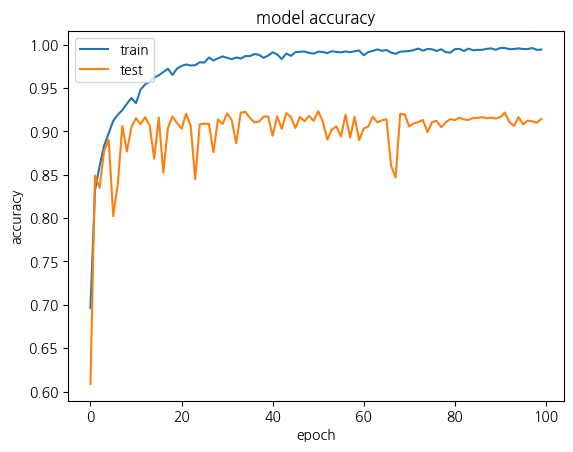

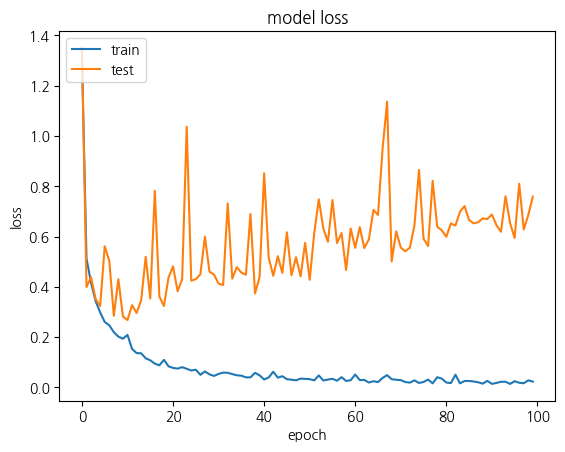

In [39]:
#학습결과 시각화
plt.plot(model_fit_history.history['accuracy'])
plt.plot(model_fit_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(model_fit_history.history['loss'])
plt.plot(model_fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
#테스트 데이터셋으로 평가 진행
model_evaluate_result = model.evaluate(test_images, test_labels, batch_size=1)

4221/4221 [==============================] - 13s 3ms/step - loss: 0.7454 - accuracy: 0.9190 - recall: 0.9183 - precision: 0.9207 - f1_score: 0.8797


In [47]:
print("test loss, test acc:", model_evaluate_result)

test loss, test acc: [0.7453847527503967, 0.9189765453338623, 0.9182658195495605, 0.9206650853157043, 0.8797346353530884]


In [53]:
with tf.device('CPU'):
    all_train_image, all_train_label = load_images_and_labels(all_train_images)
    model_predict = model.predict(all_train_image).argmax(axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28708/28708 [00:02<00:00, 14287.38it/s]


898/898 [==============================] - 66s 74ms/step


In [45]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

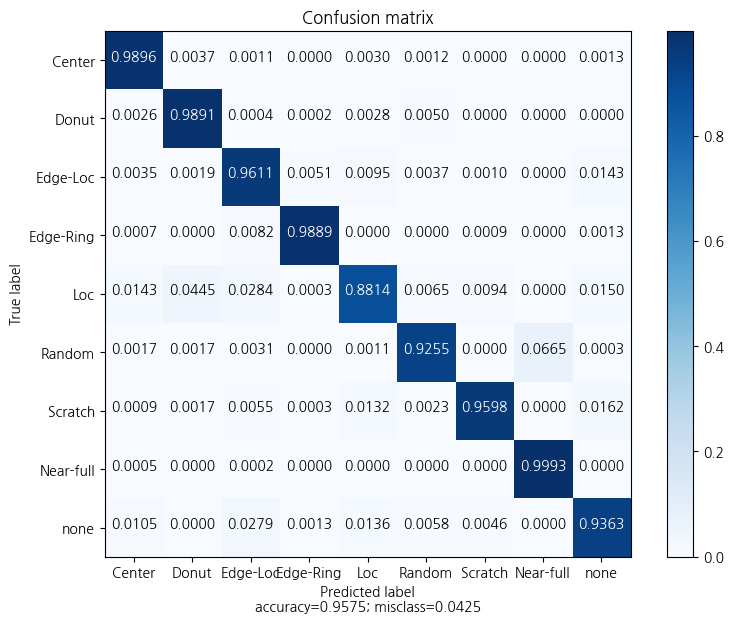

In [51]:
confusion_result = confusion_matrix(all_train_label, model_predict, normalize='pred')
plot_confusion_matrix(confusion_result, target_names=wf_train_labels, labels=True, normalize=True)

In [52]:
print(classification_report(all_train_label, model_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4294
           1       0.94      0.95      0.95       555
           2       0.92      0.97      0.95      5189
           3       0.99      0.99      0.99      9680
           4       0.96      0.91      0.93      3593
           5       0.98      0.95      0.96       866
           6       0.98      0.88      0.93      1193
           7       0.93      0.98      0.95       149
           8       0.95      0.91      0.93      3189

    accuracy                           0.96     28708
   macro avg       0.96      0.95      0.95     28708
weighted avg       0.96      0.96      0.96     28708

